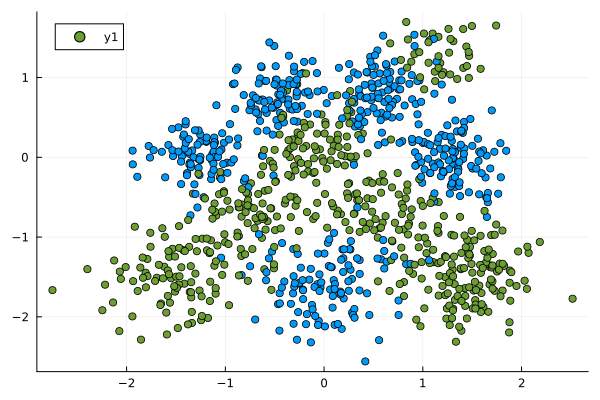

In [115]:
using DataFrames, CSV, DelimitedFiles
using Plots
using Zygote
using ForwardDiff

X = [ones(1000, 1) readdlm("X.txt", ' ', Float64)] 
y = readdlm("y.txt", ' ', Int64) 

scatter(X[:, 2], X[:, 3], markercolor=y)

## Regression

Model using:

$$ y = w^T X + b + \epsilon_n$$

where:

$$ \epsilon_n \sim \mathcal{N}(0, \sigma^2) $$

by adding a third dimension to X, as done above, we can use:

$$ y = w^T \tilde{X} + \epsilon_n$$

Ultimately we have:

$$ p(y_n | \tilde{\mathbf{x}}_n, \mathbf{\theta}) = \mathcal{N}(y_n | \mathbf{w}^t \tilde{\mathbf{x}}_n, \sigma^2) $$



## Logistic Regression

$$\begin{align*}
 p(y_n | \tilde{\mathbf{x}}_n, \mathbf{\theta}) &= y_n \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n) + (1 - y_n) (1 - \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n))\\
&= y_n \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n) + (1 - y_n)  \sigma (-\mathbf{w}^T \tilde{\mathbf{x}}_n)\\
\end{align*}$$


In [116]:
logistic(X) = 1 / (1 + exp(-clamp.(X, -1000, 1000)))

likelihood(X, y, w) = y .* logistic.(X * w) .+ (1 .- y) .* logistic.(-X * w)

log_loss(X, y, w) = sum(log.(likelihood(X, y, w)))

log_loss (generic function with 1 method)

-1278.5548825257467


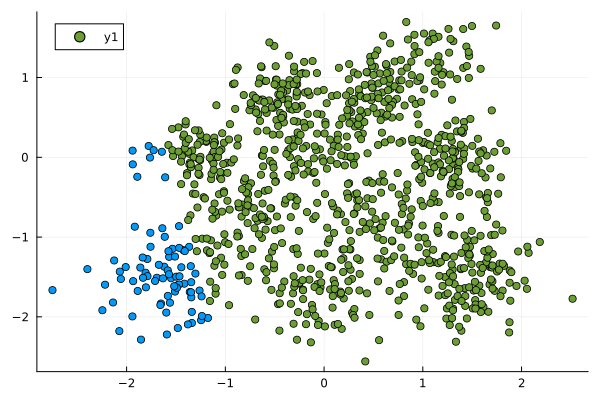

In [117]:
w = randn(3, 1)
predictions = logistic.(X * w)
binary_pred = predictions .|> (x -> x < 0.5 ? 0 : 1)

println(log_loss(X, y, w))
scatter(X[:, 2], X[:, 3], markercolor=binary_pred)


In [118]:
# Gradient ascent
function train(Input, labels; lr=0.01, epochs=20_000)
    n_features = size(Input, 2)
    params = randn(n_features, 1) .* 0.01 # Initialize weights
    println("Initial log likelihood = $(log_loss(Input, labels, params))")
    
    for i in 1:epochs
        lr = lr * 0.9999  # Decrease learning rate
        # Compute gradient using Zygote
        grad = Zygote.gradient(params -> log_loss(Input, labels, params), params)[1]

        # Update weights (ascent because we're maximizing)
        params .+= lr * grad

        # Print progress every 100 epochs
        if i % 10_000 == 0
            loss = log_loss(Input, labels, params)
            println("Epoch $i: log likelihood = $loss")
            
            
        end
    end
    println("Training complete.")
    println("Final log likelihood = $(log_loss(Input, labels, params))")
    return params
end

train (generic function with 1 method)

Initial log likelihood = -695.9494639206582
Epoch 10000: log likelihood = -623.4619710586629
Epoch 20000: log likelihood = -623.4619710586629
Training complete.
Final log likelihood = -623.4619710586629


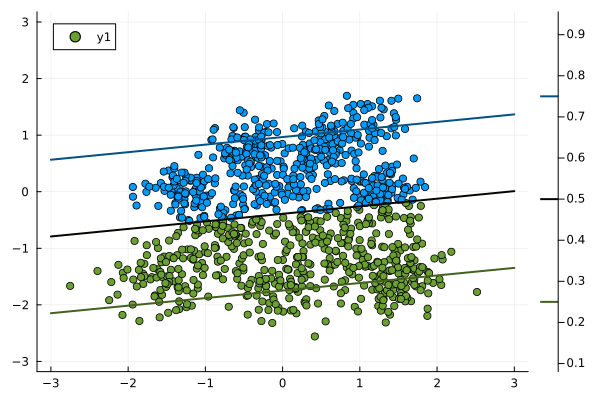

In [128]:
w_opt = train(X, y)
pred = logistic.(X * w_opt)
binary_pred = pred .|> (x -> x < 0.5 ? 0 : 1)

scatter(X[:, 2], X[:, 3], markercolor=binary_pred)
contour!(-3:0.01:3, -3:0.01:3, 
        (x, y) -> logistic.([1 x y] * w_opt)[1], 
        levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)


Initial log likelihood = -694.6318039104424
Epoch 10000: log likelihood = -767.0400735419812
Epoch 20000: log likelihood = -748.1254345359395
Training complete.
Final log likelihood = -748.1254345359395


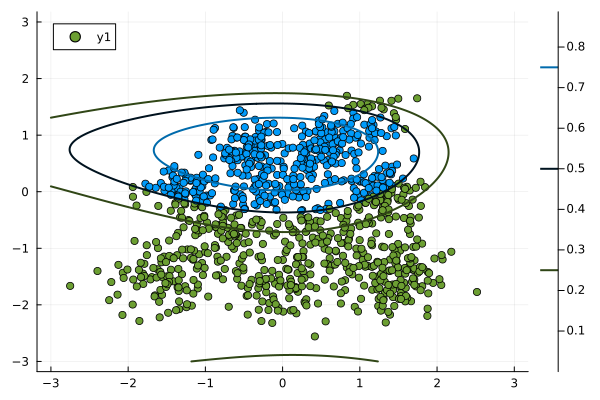

In [120]:
X_nl = [X X[:, 2].^2 X[:, 3].^2 X[:, 2].*X[:, 3] X[:, 2].^3 X[:, 3].^3]

w_opt_nl = train(X_nl, y)
predictions = logistic.(X_nl * w_opt_nl)
binary_pred = predictions .|> (x -> x < 0.5 ? 0 : 1)

scatter(X[:, 2], X[:, 3], markercolor=binary_pred)
contour!(-3:0.01:3, -3:0.01:3, 
         (x, y) -> logistic.([1 x y x*x y*y x*y x*x*x y*y*y] * w_opt_nl)[1], 
         levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)